# Network Modifications - Transit

In this notebook a copy of our baseline NetworkDataset is made to be modified reflecting the candidate improvement.


New service is modelled by adding a new lines (and connections) to the TransitRoutes layer. Note, "stops" only exist where explicitly defined.

### Assumed Operating Speeds

Route Type | Operating Speed
---- | ----
BRT|30 mph
Commuter Rail|30 mph
Core route|16 mph
Express bus|Exclude, there are only a few of these per day
Light rail|20 mph
Local route|13 mph
Street car|11 mph

Average speeds of commuter rail routes are 29 mph.

Average speeds of current bus routes:

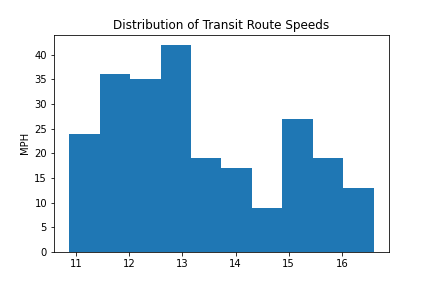

### Improvements Table

Project Type (new and upgrades)|Action
---- | ----
Bus rapid transit (line)|Add line (new) or change route type & increase speed (upgrade)
Commuter rail (line) - extension|(probably evaluated in regional TDM)
Core route (line)|Add line (new)
Light rail (line)|Add line (new)
Street car (line)|Add line (new)

Ignoring for now: Express bus (line), Park & Ride, Infill Station

In [16]:
import arcpy
import os
import shutil
from arcgis.features import SpatialDataFrame
import pandas as pd

arcpy.CheckOutExtension("network")

base_path = os.path.abspath(".")
base_gdb = os.path.join(base_path, "baseline.gdb")
target_gdb =  os.path.join(base_path, "mod.gdb")
nd = os.path.join(target_gdb, r"NetworkDataset\NetworkDataset_ND")

In [17]:
# if mod.gdb exists, delete it
if os.path.isdir(target_gdb):
    shutil.rmtree(target_gdb)

arcpy.management.CreateFileGDB(base_path, "mod")

arcpy.env.workspace = target_gdb

# Copy our baseline network dataset to our dataset for modification
arcpy.management.Copy(
    os.path.join(base_gdb, r"NetworkDataset"), 
    os.path.join(target_gdb, "NetworkDataset")
)

<Result 'C:\\wfrc\\ato\\mod.gdb\\NetworkDataset'>

## New Route

1. Add new feature to TransitRoutes Layer. 
2. Create new stops as required. Make sure that vertex points are coincident between a) the BikePedAuto layer; b) the TransitRoutes layer; and c) the TransitStops layer. This layer connectivity (connected by coincident vertices and TransitStop features) is essential for the correct function of Network Analyst.
3. Ensure that geometry precisely connects to stops. Zoom way in.
4. Select new feature, uncomment the appropriate speed in the cell below, and run to set travel times.

## Service Upgrade

1. Select affected feature, uncomment the appropriate speed in the cell below, and run

In [ ]:
# UPDATE TransitTime FOR SELECTED FEATURES
# SELECT ONLY AFFECTED FEATURES TO KEEP RUN TIME REASONABLE

# Uncomment the appropriate speed
#speed_mph = 30 # BRT or Commuter Rail
speed_mph = 16 # Core Route
#speed_mph = 20 # light rail
#speed_mph = 13 # local route
#speed_mph = 11 # street car

expression = '!Length_Miles! * 60 / ' + str(speed_mph)

if 0 < int(arcpy.management.GetCount("TransitRoutes")[0]) < 100:
    arcpy.management.CalculateField("TransitRoutes", 
                                    "Length_Miles", '!Shape_Length! * 0.000621371', "PYTHON3", None, "DOUBLE")
    arcpy.management.CalculateField("TransitRoutes", "TransitTime", 
                                    expression, "PYTHON3", None, "DOUBLE")
else:
    print("Warning: operation will affect " + 
          arcpy.management.GetCount("TransitRoutes")[0] + 
          " features - did you select only the intended target?")

Save edits to layers

In [19]:
# save edits

# clear the selection before creating the new network dataset
arcpy.management.SelectLayerByAttribute("TransitRoutes", "CLEAR_SELECTION")
arcpy.management.SelectLayerByAttribute("TransitStops", "CLEAR_SELECTION")

# delete existing network
arcpy.management.Delete(nd)

# create network dataset from template
arcpy.na.CreateNetworkDatasetFromTemplate(
    os.path.join(base_path, "template.xml"),                 
    os.path.join(target_gdb, "NetworkDataset")
)
# finally, build the dataset
arcpy.na.BuildNetwork(nd)

<Result 'C:\\wfrc\\ato\\mod.gdb\\NetworkDataset\\NetworkDataset_ND'>

In [20]:
test_network(nd, mode = "Transit")

Testing integrity of network C:\wfrc\ato\mod.gdb\NetworkDataset\NetworkDataset_ND
Network validation: PASS


In [ ]:
# delete existing network
arcpy.management.Delete(nd)

# create network dataset from template
arcpy.na.CreateNetworkDatasetFromTemplate(
    os.path.join(base_path, "template.xml"),                 
    os.path.join(target_gdb, "NetworkDataset")
)
# finally, build the dataset
arcpy.na.BuildNetwork(nd)

In [ ]:
test_network(nd, mode = "Transit")